## Comparing the performance of Gated Recurrent Units With and Without Attention
By learning to predict the text of H.G. Wells' The Time Machine

### Dataset

In [1]:
raw_text = open('../datasets/timemachine.txt').read()

### Let's tokenize the dataset


In [2]:
import re
from transformers import AutoTokenizer

# Remove punctuation and convert to lowercase
text = raw_text.lower()
text = re.sub(r'[^a-z]+', ' ', text)

# Tokenize into characters
char_tokenized_text = list(text)

/Users/vikram/dev/xjax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
",".join(char_tokenized_text[200:300])

's,e, ,i,t, ,u,n,d,e,r, ,t,h,e, ,t,e,r,m,s, ,o,f, ,t,h,e, ,p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,l,i,c,e,n,s,e, ,i,n,c,l,u,d,e,d, ,w,i,t,h, ,t,h,i,s, ,e,b,o,o,k, ,o,r, ,o,n,l,i,n,e, ,a,t, ,w,w,w, ,g,u,t'

In [4]:
# Most common tokens
from collections import Counter
# Flatten the list of tokens
# Count the tokens
token_counts = Counter(char_tokenized_text)
print(f"Total tokens: {len(token_counts)}")
# Most common tokens
most_common_tokens = token_counts.most_common(10)
for token, count in most_common_tokens:
    print(f"{token} {count}")

Total tokens: 27
  35850
e 19667
t 15040
a 12700
i 11254
o 11082
n 10943
s 9242
r 8833
h 8786


[35850, 19667, 15040, 12700, 11254, 11082, 10943, 9242, 8833, 8786, 6859, 6629, 4411, 4310, 4023, 3735, 3496, 3490, 3001, 2870, 2172, 1407, 1219, 264, 185, 146, 106]


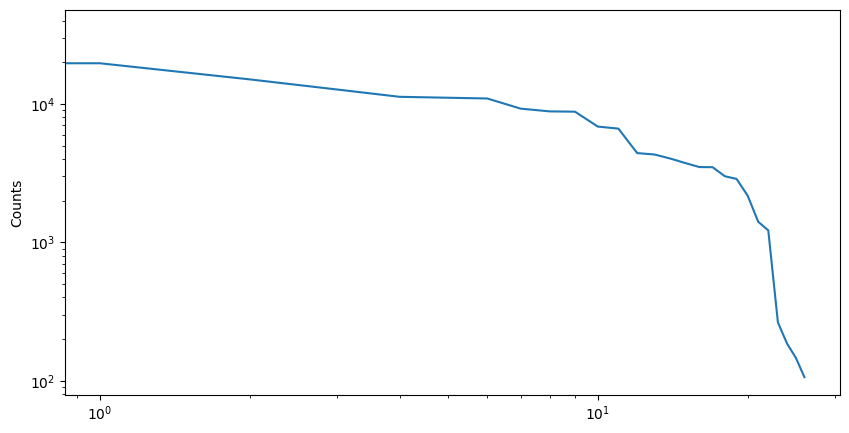

In [5]:
# Draw a graph of the token counts 
import matplotlib.pyplot as plt
# Get the tokens and counts
counts = [count for token, count in token_counts.items()]
# Sort the tokens and counts
sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
sorted_counts = sorted(counts, reverse=True)
print(sorted_counts)
# Plot the counts using a log scale
plt.figure(figsize=(10, 5))
plt.loglog(sorted_counts)
plt.ylabel('Counts')
plt.show()

In [6]:
MIN_FREQ = 1 ## Minimum token frequency to include in the vocab

### Generate the Vocabulary
tok_to_idx = {}
idx_to_tok =  list(sorted(set(['<unk>'] + [tok for tok,count in token_counts.items() if count >= MIN_FREQ])))
tok_to_idx = {tok: idx for idx, tok in enumerate(idx_to_tok)}


# Vocabulary size
vocab_size = len(idx_to_tok)
print(f"Vocabulary size: {vocab_size}")



Vocabulary size: 28


In [7]:
import jax.numpy as jnp

def sliding_window(seq, window_size, overlap):
    for i in range(0, len(seq) - window_size, window_size - overlap):
        yield [ tok_to_idx[tok] if tok in tok_to_idx else tok_to_idx['<unk>'] for tok in seq[i:i + window_size] ]


## Generate dataset 
def generate_data(text, seq_length, overlap):
    num_tokens = len(char_tokenized_text)
    return jnp.array([ seq for seq in sliding_window(char_tokenized_text, seq_length, overlap)])

In [8]:
SEQUENCE_LENGTH = 32
WINDOW_OVERLAP = 0

data = generate_data(text, SEQUENCE_LENGTH, WINDOW_OVERLAP)
X = data[:,:-1]
Y = data[:,1:]

print(X.shape, Y.shape)
print([idx_to_tok[i] for i in X[0]])
print([idx_to_tok[i] for i in Y[0]])


(5991, 31) (5991, 31)
['p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 's', ' ', 't', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a']
['r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 's', ' ', 't', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c']


In [9]:
import jax

from xjax.models import gru

rng = jax.random.key(42)

HIDDEN_SIZE=32
EPOCHS=50
LEARNING_RATE = 10**(-3)
MAX_GRAD = 1

params, model = gru.gru(rng, vocab_size=vocab_size, hidden_size=HIDDEN_SIZE)

# I train a GRU model on the data 
#trained_params = gru.train(model, rng=rng, params=params, 
#                                            X=X, Y=Y, 
#                                            vocab_size=vocab_size, 
#                                            batch_size=1024,
#                                            num_epochs=EPOCHS, 
#                                            learning_rate=LEARNING_RATE,
#                                            max_grad=MAX_GRAD)



TypeError: dot_general requires contracting dimensions to have the same shape, got (32,) and (28,).